<a href="https://colab.research.google.com/github/desmond-ong/pplAffComp/blob/master/Colab/PPLTutorial_2_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating emotional faces using a Variational Autoencoder

In the previous example, we saw how to specify a "theory" of how people feel in response to outcomes. But it is impossible to specify by hand other processes, such as how emotions translate into facial expressions. We can posit a theory that feeling an emotion may 'cause' someone to display some facial expressions (e.g. *happy* 'causes' smiling, *anger* 'causes' a furrowing of the eyebrows), but it may not be practical to spell out all the possible sets of muscular configurations---as well as variance in these configurations---that accompany each emotion. Thus, from a computational standpoint, we have to be able to learn how to "read" unstructured data like images of faces (or audio, or video, or text).

In this example, as a first step towards this goal, we consider a simple model, called the Variational Autoencoder (Kingma et al, 2014), to learn to generate emotional faces.

(This example is adapted from the Pyro [VAE Tutorial](http://pyro.ai/examples/vae.html))

We consider the following graphical model:

<div style="width: 300px; margin: auto;"> <center>
<img src="https://desmond-ong.github.io/pplAffComp/code/images/graphicalModel_VAE.png" width=300></img> </center>
</div>

We have an observed variable, **Facial Expressions**, which we assume is 'caused' by some latent parameter $z$. This parameter captures information about how faces vary. The transformation from this latent $z$ to Expressions, $p_{\theta}(\text{face }|\text{ z})$ is parameterized by $\theta$ (and this can be any general function, like a neural network). 

The parameters $\theta$ can be approximated using a technique called stochastic variational inference (SVI; e.g. Hoffman et al, 2013), which we saw briefly in the last example as well. Briefly, this involves maximizing a quantity called the evidence lower bound (ELBO), much like how a loss function is minimized during many machine learning approaches. The ELBO contains the posterior $p(z\text{ } | \text{ face})$, which is often intractable to compute, and with some assumptions we can approximate this posterior using a **guide** function (also called the variational distribution), $q_\phi(z\text{ } | \text{ face})$, that can also be parameterized using neural networks. This is the basis of the popular Variational Autoencoder (VAE; Kingma & Welling, 2014) that has received significant attention in the deep learning community.

The core of the VAE (in Pyro) is very simple. We have two neural networks, an `encoder` and a `decoder`. The `encoder` is a neural network that takes in the facial expressions, and "encodes" it into the latent space (i.e., it parameterizes the distribution $q(z| \text{ face})$). The `decoder` is a neural network that takes a value in the latent space and "decodes" it into an image (i.e., it models the likelihood $p_\theta(\text{face }|z)$).


In the main `model()` function, when we are given a new image, we sample $z$ from its prior distribution. We then run $z$ through the `decoder` (i.e., the neural network that maps $z$ onto the facial expressions), and then sample the facial expression conditioned upon the observed image.

```
class VAE():
    def model(self, image):
        # sample z given priors
        z = pyro.sample("z", dist.Normal(prior_location, prior_scale))
        # generate the face using z
        # condition on observed image
        loc = self.decoder(z)           
        pyro.sample("face", dist.Bernoulli(loc), obs=image)
```

## Preamble

These first chunks of code clones the GitHub repo, installs Pyro and other requirements on the Colab server (if not already installed), and imports the necessary python packages and functions that we will use.

In [1]:
!git clone https://github.com/desmond-ong/pplAffComp.git
%cd pplAffComp/code
!pip install torch torchvision pyro-ppl

Cloning into 'pplAffComp'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 725 (delta 14), reused 15 (delta 7), pack-reused 696
Receiving objects: 100% (725/725), 156.32 MiB | 34.35 MiB/s, done.
Resolving deltas: 100% (313/313), done.
/content/pplAffComp/code
     |████████████████████████████████| 235kB 2.8MB/s 
     |████████████████████████████████| 61kB 19.4MB/s 
     |████████████████████████████████| 51kB 18.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/37/6b/8b/8d15c6042ed38db155158baf56c1949a6e12d5d709697b0c37
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built pyro-ppl opt-einsum
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.1.0 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [2]:
#from __future__ import division, print_function, absolute_import
import os
import urllib # for urllib.urlretrieve()

import numpy as np
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from torchvision import transforms, utils, datasets
from PIL import Image
import helperCode

print "Currently using Pyro version: " + pyro.__version__

IMG_WIDTH = 100
IMG_SIZE = IMG_WIDTH*IMG_WIDTH*3
BATCH_SIZE = 10
DEFAULT_HIDDEN_DIMS = 400
DEFAULT_Z_DIM = 50

Currently using Pyro version: 0.3.3


### Additional, unlabelled faces

In the orignial Cognition dataset we saw in the last example, we only had 18 unique faces. This may be too little for the model to learn a latent $z$, and so we generated an addition 203 faces (which are in `../CognitionData/more_faces/`).
This is still a small number of faces, but these faces were generated from a software (FaceGen) in which we kept the race and gender (and viewing angle, brightness, etc) of the face constant and varied the expression on the face. Thus these 200+ faces should contain mostly muscular changes that the model may be able to learn.


Here is a preview of them.

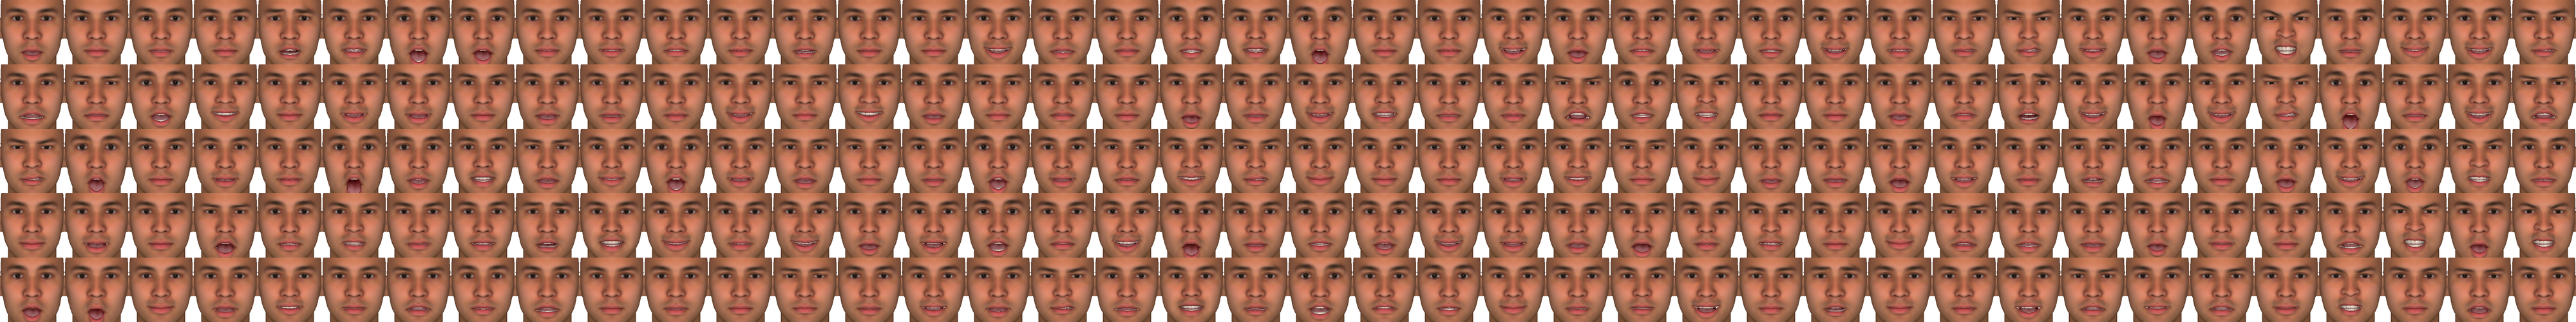

In [3]:
more_faces_path = os.path.join(os.path.abspath('..'), "CognitionData", "more_faces")
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])
more_faces_dataset = datasets.ImageFolder(root=more_faces_path, transform=data_transform)
more_faces_loader = torch.utils.data.DataLoader(more_faces_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=4)


# initializing temp arrays
faceArray1 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray2 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray3 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray4 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray5 = np.zeros(shape=(100,1,3), dtype='uint8')

count = 0
for faceFilename in os.listdir(os.path.join(more_faces_path, 'img')):
  newFaceArray = np.array(Image.open(os.path.join(more_faces_path, 'img', faceFilename)))
  if count < 40:
    faceArray1 = np.concatenate((faceArray1, newFaceArray), axis=1)
  elif count < 80:
    faceArray2 = np.concatenate((faceArray2, newFaceArray), axis=1)
  elif count < 120:
    faceArray3 = np.concatenate((faceArray3, newFaceArray), axis=1)
  elif count < 160:
    faceArray4 = np.concatenate((faceArray4, newFaceArray), axis=1)
  elif count < 200:
    faceArray5 = np.concatenate((faceArray5, newFaceArray), axis=1)
  count += 1

# concatenating the arrays and removing the first temp column
faceArray = np.concatenate((faceArray1, faceArray2, faceArray3, faceArray4, faceArray5), axis=0)
faceArray = faceArray[:,1:,:]
Image.fromarray(faceArray)

### Defining the encoder and decoder networks:

Here, we define the `Encoder` and `Decoder` modules, basically the two neural networks that go from image to $z$, and $z$ to image, respectively.

In [0]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(IMG_SIZE, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, IMG_SIZE)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, IMG_SIZE)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img


## Model

In [0]:
# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size(0)):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, IMG_SIZE))
            # return the loc so we can visualize it later
            return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.size(0)):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img


### Training

Next we define the parameters of our training session, and set up the model and inference algorithm. This part is identical to the linear regression example.

Since the training takes a while, `num_epochs` below is set to 2 just to demonstrate training. Ideally you'll want to train for much longer.

In [0]:
class Args:
    learning_rate = 5e-5
    num_epochs = 2 #1000
    hidden_layers = DEFAULT_HIDDEN_DIMS
    z_dim = DEFAULT_Z_DIM
    seed = 10
    cuda = False
    visdom_flag = False
    #visualize = True
    #logfile = "./tmp.log"
    
args = Args()

# setup the VAE
vae = VAE(z_dim=args.z_dim, hidden_dim=args.hidden_layers, use_cuda=args.cuda)

# setup the optimizer
adam_args = {"lr": args.learning_rate}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

### Training loop

This next chunk of code runs the training over `num_epochs` epochs.

In [7]:
train_elbo = []
# training loop
for epoch in range(args.num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for batch_num, (x, _) in enumerate(more_faces_loader):
        # if on GPU put mini-batch into CUDA memory
        if args.cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        #print("Batch: ", batch_num, "out of", len(train_loader))
        epoch_loss += svi.step(x)

    # report training diagnostics
    normalizer_train = len(more_faces_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    train_elbo.append(total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 20789.7187
[epoch 001]  average training loss: 19612.2955


It takes a while to train (For 1000 epochs, ~7 hours on a 3GHz CPU with 128GB RAM, probably faster with a gpu but far too slow for a laptop in a tutorial). Thus you can use the following two chunks to save or load a model. We assume that you'll skip this save step and load the model from `trained_models/`. It's a large file so you can download it from: https://www.dropbox.com/s/eknoyrig6wjkp08/vae_pretrained.save?dl=1 and put it into `trained_models/`

In [0]:
# save model if you decide to modify the above code to train your own model
savemodel = False
if savemodel:
    if not os.path.exists('trained_models'):
      os.mkdir('trained_models')
    pyro.get_param_store().save('trained_models/vae_pretrained.save')

In [9]:
## making a "trained_models" directory
if not os.path.exists('trained_models'):
    os.mkdir('trained_models')

## use this chunk to download a saved version of the model directly onto colab
downloadmodel = True
if downloadmodel:
    urllib.urlretrieve(
        "https://www.dropbox.com/s/eknoyrig6wjkp08/vae_pretrained.save?dl=1", 
        "trained_models/vae_pretrained.save")
    print("Model downloaded")

## use this chunk to help upload the file if you have it on your local machine
#from google.colab import files
#!mkdir trained_models
#%cd trained_models
#files.upload()
#%cd ..

Model downloaded


In [0]:
loadmodel = True
if loadmodel:
    pyro.get_param_store().load('trained_models/vae_pretrained.save')
    pyro.module("decoder", vae.decoder, update_module_params=True)
    pyro.module("encoder", vae.encoder, update_module_params=True)

Now, let's reconstruct some faces! We defined a function, `vae.reconstruct_img()`, that allows us to sample from $z$ and generate a reconstructed image.

- In the top row, we show 10 random samples from the training set.
- In the bottom row, we show reconstructions from the faces in the top row.
- Notice that the bottom set of faces are slightly different from the top set of faces.
- Sampling is also stochastic, so if you re-run this chunk you will get different results.

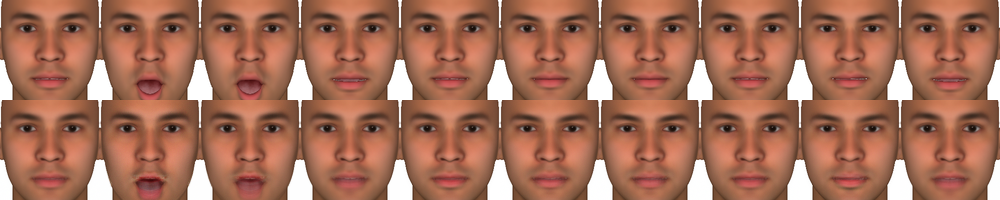

In [11]:
NUM_SAMPLES = 10
input_array = np.zeros(shape=(IMG_WIDTH, 1, 3), dtype="uint8")
reconstructed_array = np.zeros(shape=(IMG_WIDTH, 1, 3), dtype="uint8")

for i, (x, _) in enumerate(more_faces_loader):
    # pick NUM_SAMPLES random test images from the first mini-batch and
    # visualize how well we're reconstructing them
    if i == 0:
        reco_indices = np.random.randint(0, x.size(0), NUM_SAMPLES)
        for index in reco_indices:
            input_img = x[index, :]
            # storing the input image
            input_img_display = np.array(input_img*255., dtype='uint8')
            input_img_display = input_img_display.transpose((1, 2, 0))
            input_array = np.concatenate((input_array, input_img_display), axis=1)

            # generating the reconstructed image and adding to array            
            reconstructed_img = vae.reconstruct_img(input_img)
            reconstructed_img = reconstructed_img.view(3, IMG_WIDTH, IMG_WIDTH).detach().numpy()
            reconstructed_img = np.array(reconstructed_img*255., dtype='uint8')
            reconstructed_img = reconstructed_img.transpose((1, 2, 0))
            reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)

# remove first, blank column, and concatenate
input_array = input_array[:,1:,:]
reconstructed_array = reconstructed_array[:,1:,:]
display_array = np.concatenate((input_array, reconstructed_array), axis=0)
Image.fromarray(display_array)

## Coda

That's great! We've constructed and trained a deep generative model that learns how to generate emotional faces! Specifically, we've learnt a latent parameter $z$, along with variational parameters $\theta$, that allow the model to generate emotional faces.

But wait, it does not actually learn anything about emotions. It can generate emotional faces, but it has no idea what emotions those faces convey (because we did not tell the model anything about the emotions). We'll extend this model in the next example (Semi-Supervised VAE) to do so!

-----

Written by: Desmond Ong (desmond.c.ong@gmail.com)

References:

Pyro [VAE tutorial](http://pyro.ai/examples/vae.html)

Hoffman, M. D., Blei, D. M., Wang, C., & Paisley, J. (2013). Stochastic
variational inference. *The Journal of Machine Learning Research*, 14(1),
1303-1347.

Kingma, D. P., & Welling, M. (2014). Auto-encoding variational bayes. Auto-Encoding Variational Bayes. In *The International Conference on Learning Representations*. https://arxiv.org/abs/1312.6114

Data from https://github.com/desmond-ong/affCog, from the following paper:

Ong, D. C., Zaki, J., & Goodman, N. D. (2015). Affective Cognition: Exploring lay theories of emotion. *Cognition*, 143, 141-162.